In [49]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import util as utl

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [50]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

In [51]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
# X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_scores(model, X, y, w='macro'):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    print('Accuracy: ', acc)
    print('Precision: ', precision_score(y, y_pred, average=w))
    print('Recall: ', recall_score(y, y_pred, average=w))
    print('F1: ', f1_score(y, y_pred, average=w))

In [53]:
knn_clf = utl.load_model("knn_clf")
sgd_clf = utl.load_model("sgd_clf")
rf_clf = utl.load_model("rf_clf")

In [54]:
print_scores(knn_clf, X_train, y_train)

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0


In [55]:
print_scores(knn_clf, X_test, y_test)

Accuracy:  0.9717
Precision:  0.9719031233123564
Recall:  0.9713357268999042
F1:  0.971528765919764


In [56]:
from sklearn.model_selection import ShuffleSplit, LearningCurveDisplay

def draw_learning_curve(model, X, y, score_method, title):
    common_params = {
        "X": X,
        "y": y,
        "train_sizes": np.linspace(0.1, 1.0, 5),
        "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
        "score_type": "both",
        "scoring": score_method,
        "line_kw": {"marker": "o"},
        "std_display_style": 'fill_between',
    }
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.subplots_adjust(hspace=0.5)

    LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Train Score", "Test Score"])
    ax.set_title(title)
    ax.set_xlabel("Set size")
    ax.grid(True)

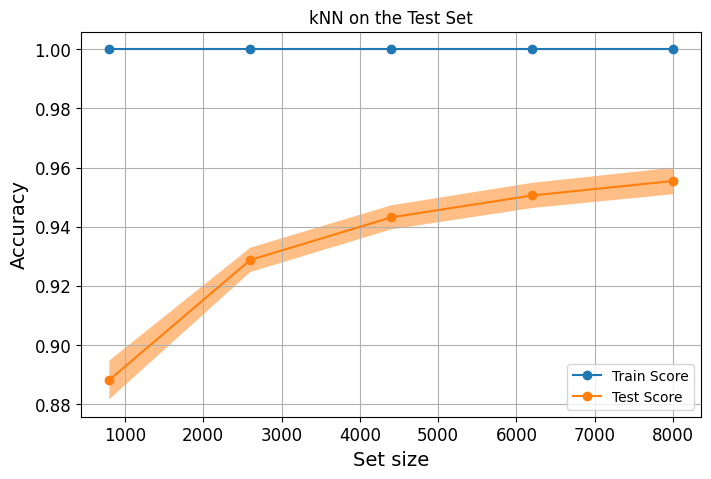

In [57]:
draw_learning_curve(knn_clf, X_test, y_test, "accuracy", 'kNN on the Test Set')

In [58]:
def draw_learning_curves(estimators, X, y, score_method):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharey=True)
    plt.subplots_adjust(hspace=0.2)

    common_params = {
        "X": X,
        "y": y,
        "train_sizes": np.linspace(0.1, 1.0, 5),
        "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=42),
        "score_type": "both",
        "scoring": score_method,
        "line_kw": {"marker": "o"},
        "std_display_style": 'fill_between',
    }

    for i in range(len(estimators)):
        LearningCurveDisplay.from_estimator(estimators[i], **common_params, ax=axs[i])
        handles, label = axs[i].get_legend_handles_labels()
        axs[i].legend(handles[:2], ["Train Score", "Test Score"])
        axs[i].set_title(f"Learning Curve of {estimators[i].__class__.__name__}")
        axs[i].set_xlabel("Set size")
        if i > 0:
            axs[i].set_ylabel("")
        axs[i].grid(True)

Saving figure learning_curve_knn_sgd_rf


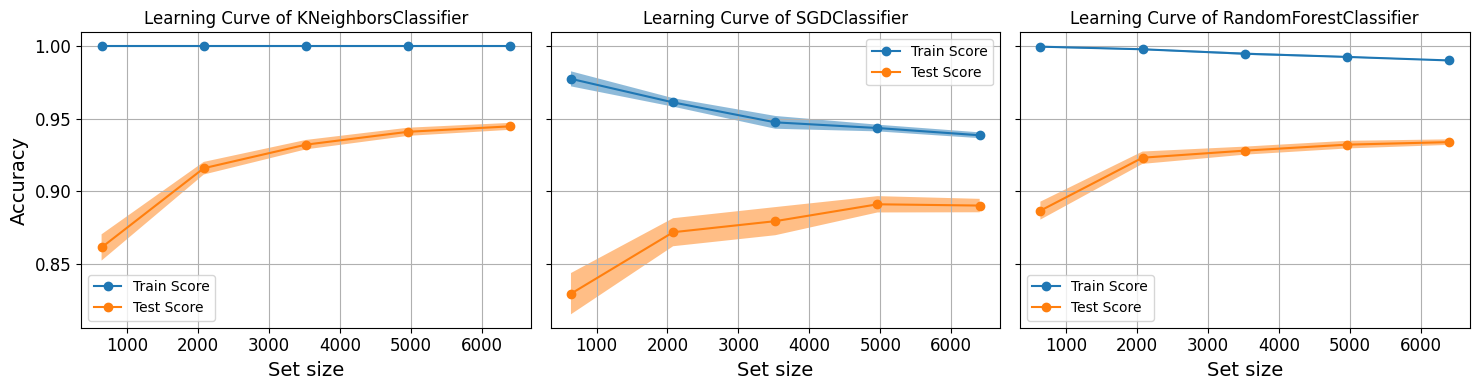

In [59]:
draw_learning_curves(estimators=[knn_clf, sgd_clf, rf_clf], X=X_train[:8000], y=y_train[:8000], score_method="accuracy")
save_fig("learning_curve_knn_sgd_rf")

In [62]:
from sklearn.model_selection import learning_curve, ShuffleSplit

def draw_scalabilities(estimators, X, y):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

    for i in range(len(estimators)):
        common_params = {
            "X": X,
            "y": y,
            "train_sizes": np.linspace(0.1, 1.0, 5),
            "cv": ShuffleSplit(n_splits=3, test_size=0.2, random_state=42),
            "n_jobs": 4,
            "return_times": True,
        }

        train_sizes, _, test_scores_nb, fit_times_nb, score_times_nb = learning_curve(
            estimators[i], **common_params
        )

        ax[0, i].plot(train_sizes, fit_times_nb.mean(axis=1), "o-")
        ax[0, i].fill_between(
            train_sizes,
            fit_times_nb.mean(axis=1) - fit_times_nb.std(axis=1),
            fit_times_nb.mean(axis=1) + fit_times_nb.std(axis=1),
            alpha=0.3
        )
        ax[0, i].set_ylabel("Fit time (s)")
        ax[0, i].set_title(f"{estimators[i].__class__.__name__}")

        ax[1, i].plot(train_sizes, score_times_nb.mean(axis=1), "o-")
        ax[1, i].fill_between(
            train_sizes,
            score_times_nb.mean(axis=1) - score_times_nb.std(axis=1),
            score_times_nb.mean(axis=1) + score_times_nb.std(axis=1),
            alpha=0.3,
        )
        ax[1, i].set_ylabel("Score time (s)")
        ax[1, i].set_xlabel("Number of training samples")

        if i > 0:
            ax[0, i].set_ylabel("")
            ax[1, i].set_ylabel("")

Saving figure scalability_knn_sgd_rf


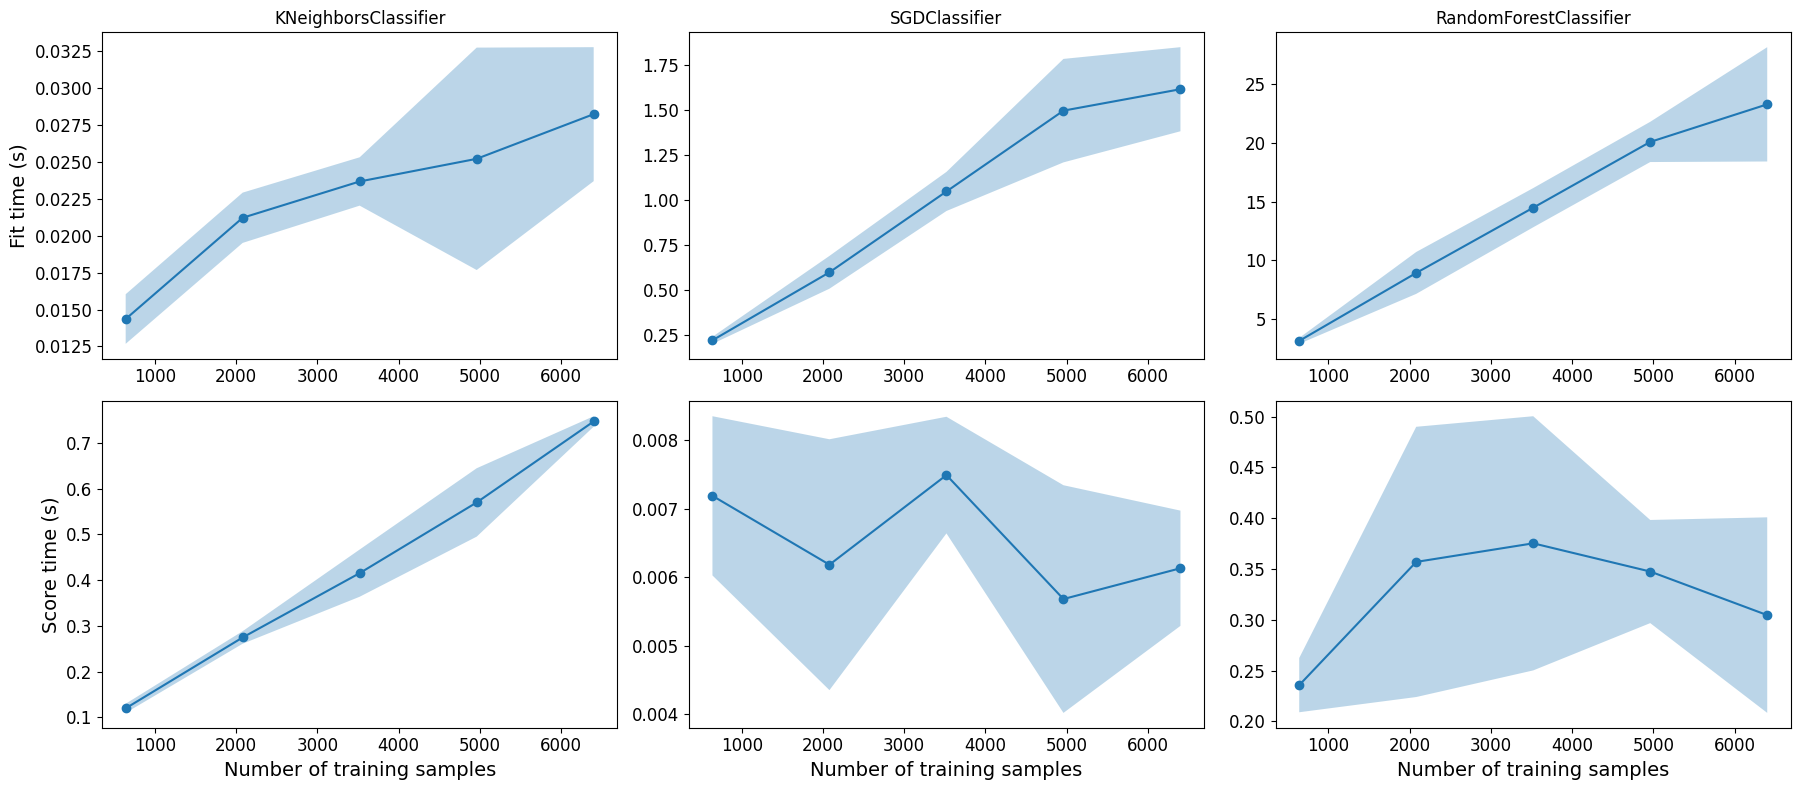

In [63]:
draw_scalabilities(estimators=[knn_clf, sgd_clf, rf_clf], X=X_train[:8000], y=y_train[:8000])
save_fig("scalability_knn_sgd_rf")